# Weather Data Preprocessing

#### TODO: report types handling, handle the rest of compound fields (look at https://www.airppm.org/for-participants/training-sets), outliers handling
#### TODO: final goal -> combine the weather files with the air quality measurements to start training a model

## Imports

In [170]:
import pandas as pd
import numpy as np
from pathlib import Path

## Merge Weather Files
- merge all the available weather files
- get rid of irrelevant columns

In [171]:
weather_dir = Path("../data/raw/Weather_Krakow")

weather_files = sorted(weather_dir.glob("*.csv"))

dfs = []

for f in weather_files:
    df = pd.read_csv(f, dtype=str)
    df['year_file'] = f.stem
    dfs.append(df)
    
# Normalize column names
dfs = [df.rename(columns=lambda x: x.strip()) for df in dfs]
df = pd.concat(dfs, ignore_index=True, sort=False)

# drop station related or constant columns
df = df.drop(columns=[
    "STATION", # only 1 station
    "SOURCE", # always 4
    "CALL_SIGN", # always 99999
    "QUALITY_CONTROL", # always V020
    "NAME", #always BALICE, PL
    "ED1", #either missing or 25,U,9999,9
    "LATITUDE", "LONGITUDE", "ELEVATION",
    "REM" #random codes
])

print(df.shape)
print(df.columns)
df.to_csv("../data/processed/weather_all_years.csv", index=False)

(130328, 35)
Index(['DATE', 'REPORT_TYPE', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'AA1',
       'AA2', 'AJ1', 'AY1', 'AY2', 'AZ1', 'AZ2', 'GA1', 'GA2', 'GA3', 'GE1',
       'GF1', 'IA1', 'KA1', 'KA2', 'MA1', 'MD1', 'MW1', 'MW2', 'MW3', 'OC1',
       'OD1', 'OD2', 'OD3', 'EQD', 'year_file', 'IA2'],
      dtype='object')


In [172]:
df = pd.read_csv("../data/processed/weather_all_years.csv", dtype=str)

## Drop columns with >90% missing values

In [173]:
# assuming your DataFrame is called df
missing_percent = df.isna().mean() * 100  # % of missing per column
cols_high_missing = missing_percent[missing_percent > 80].index.tolist()

print("Columns with >80% missing values:")
print(cols_high_missing)

df = df.drop(columns=cols_high_missing)

Columns with >80% missing values:
['AA1', 'AA2', 'AJ1', 'AY1', 'AY2', 'AZ1', 'AZ2', 'GA3', 'IA1', 'KA1', 'KA2', 'MW2', 'MW3', 'OC1', 'OD1', 'OD2', 'OD3', 'EQD', 'IA2']


## Split Compound Columns

### Wind
1. split the WND column into direction, dir_quality, type, speed and speed_quality
2. handle placeholders like 999 or 9999
3. handle the wind type meanings
4. keep only the measurements with reliable quality (1)
5. encode the wind direction as sin/cos (cyclic encoding)
6. keep the wind direction and wind speed in the final dataframe

In [174]:
# --- Split WND into parts ---
wnd_parts = df["WND"].fillna("").str.split(",", expand=True)

df["wind_dir_deg"] = pd.to_numeric(wnd_parts[0], errors="coerce")
df["wind_dir_qc"] = wnd_parts[1]
df["wind_type"]   = wnd_parts[2]
df["wind_speed_raw"] = pd.to_numeric(wnd_parts[3], errors="coerce")
df["wind_speed_qc"] = wnd_parts[4]

# --- Handle placeholder values ---
df.loc[df["wind_dir_deg"] == 999, "wind_dir_deg"] = np.nan
df.loc[df["wind_speed_raw"] == 9999, "wind_speed_raw"] = np.nan

# --- Handle wind_type meanings ---
df.loc[df["wind_type"] == "C", "wind_speed_raw"] = 0
df.loc[df["wind_type"].isin(["C","V"]), "wind_dir_deg"] = np.nan

# --- Keep only reliable measurements ---
df.loc[df["wind_dir_qc"] != "1", "wind_dir_deg"] = np.nan
df.loc[df["wind_speed_qc"] != "1", "wind_speed_raw"] = np.nan

# Cyclic encoding of wind direction
df["wind_dir_sin"] = np.sin(np.radians(df["wind_dir_deg"]))
df["wind_dir_cos"] = np.cos(np.radians(df["wind_dir_deg"]))

# --- Drop original WND column and helper columns ---
df = df.drop(columns=["WND", "wind_dir_qc", "wind_type", "wind_speed_qc", "wind_dir_deg"])

# Optional: check result
print(df.head())
print(df[["wind_speed_raw", "wind_dir_sin", "wind_dir_cos"]].describe())

                  DATE REPORT_TYPE          CIG           VIS      TMP  \
0  2019-01-01T00:00:00       FM-12  99999,9,9,N  006000,1,9,9  +0001,1   
1  2019-01-01T00:00:00       FM-15  00884,1,9,N  006000,1,9,9  +0000,1   
2  2019-01-01T00:30:00       FM-15  00610,1,C,N  006000,1,9,9  +0000,1   
3  2019-01-01T01:00:00       FM-12  99999,9,9,N  006000,1,9,9  +0008,1   
4  2019-01-01T01:00:00       FM-15  00610,1,C,N  006000,1,9,9  +0010,1   

       DEW      SLP                 GA1                 GA2  \
0  -0009,1  10302,1  07,1,+00800,1,06,1                 NaN   
1  -0010,1  99999,9  02,1,+00640,1,99,9  07,1,+00884,1,99,9   
2  -0010,1  99999,9  07,1,+00610,1,99,9                 NaN   
3  -0008,1  10299,1  07,1,+00800,1,06,1                 NaN   
4  -0010,1  99999,9  07,1,+00610,1,99,9                 NaN   

                      GE1                                  GF1  \
0  9,AGL   ,+99999,+99999  08,99,1,07,1,99,9,00800,1,99,9,99,9   
1  9,AGL   ,+99999,+99999  99,99,9,02,1,99,9

### Cloud Ceiling
1. split CIG into ceiling height, method, quality and coverage
2. convert coverage from N/Y to 0/1 
3. handle placeholder height values
4. keep only the height where method and quality were valid
5. keep the ceiling_height and ceiling_coverage in the final dataFrame

In [175]:
cig_parts = df["CIG"].fillna("").str.split(",", expand=True)

# Extract raw columns
df["ceiling_height_ft"] = pd.to_numeric(cig_parts[0], errors="coerce")
df["ceiling_method"] = cig_parts[1].replace("9", np.nan)  # only 9 → NaN
df["ceiling_quality"] = cig_parts[2].replace("9", np.nan) # only 9 → NaN
df["ceiling_coverage"] = cig_parts[3].map({"N": 0, "Y": 1, "9": np.nan})

# Handle placeholder height values
df.loc[df["ceiling_height_ft"] == 99999, "ceiling_height_ft"] = np.nan

# Keep only reliable height and coverage (non-NaN method/quality)
df.loc[df["ceiling_method"].isna() | df["ceiling_quality"].isna(), "ceiling_height_ft"] = np.nan

# Drop helper columns

df = df.drop(columns=["ceiling_method", "ceiling_quality", "CIG"])

df[["ceiling_height_ft", "ceiling_coverage"]].describe()


,ceiling_height_ft,ceiling_coverage
count,28654.000000,129317.000000
mean,748.836463,0.222067
std,620.591988,0.415637
min,0.000000,0.000000
25%,210.000000,0.000000
50%,549.000000,0.000000
75%,1219.000000,0.000000
max,10500.000000,1.000000


### Visibility
1. split the compound field
2. keep the visibility in meters only if the 2nd value is 1
3. TODO: FIGURE OUT WHERE TO CUT THE VISIBILITY CUZ 70KM IS QUITE UNREALISTIC

In [176]:
# Split the VIS column into parts
vis_parts = df["VIS"].fillna("").str.split(",", expand=True)

# Assign columns
df["visibility_m"] = pd.to_numeric(vis_parts[0], errors="coerce")      # meters
df["visibility_var"] = vis_parts[1]                                   # variability
df["visibility_quality"] = vis_parts[2]                                # quality
df["visibility_extra"] = vis_parts[3]                                  # unknown, can drop later

# Replace placeholder/missing values
df.loc[df["visibility_m"] == 99999, "visibility_m"] = np.nan
df.loc[df["visibility_m"] == 9999, "visibility_m"] = np.nan
df.loc[df["visibility_var"] != "1", "visibility_m"] = np.nan

# Display stats for all visibility columns
visibility_cols = ["visibility_m", "visibility_var", "visibility_quality", "visibility_extra"]
print(df[visibility_cols].describe(include="all"))

df = df.drop(columns=["visibility_var", "visibility_quality", "visibility_extra", "VIS"])


        visibility_m visibility_var visibility_quality visibility_extra
count   65451.000000         130328             130328           130328
unique           NaN              2                  1                1
top              NaN              1                  9                9
freq             NaN         103242             130328           130328
mean    18424.588685            NaN                NaN              NaN
std     16529.051113            NaN                NaN              NaN
min         0.000000            NaN                NaN              NaN
25%      5000.000000            NaN                NaN              NaN
50%     10000.000000            NaN                NaN              NaN
75%     30000.000000            NaN                NaN              NaN
max     70001.000000            NaN                NaN              NaN


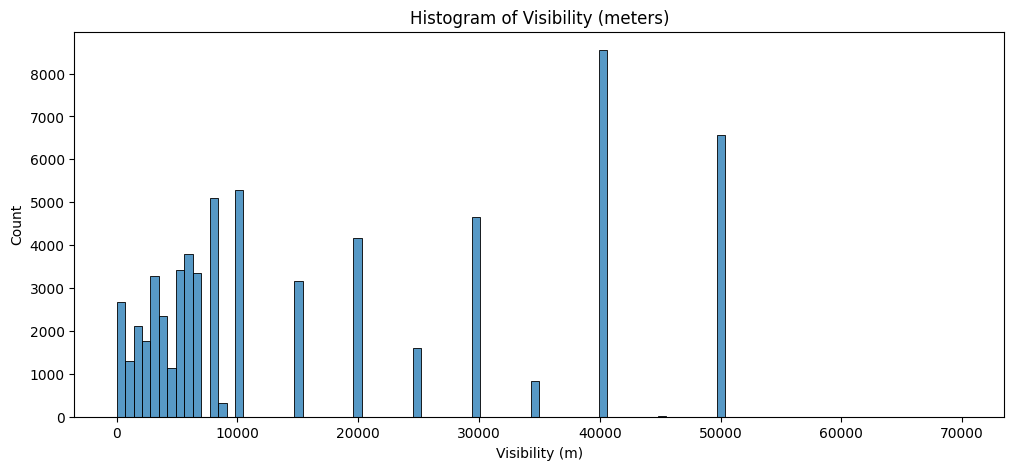

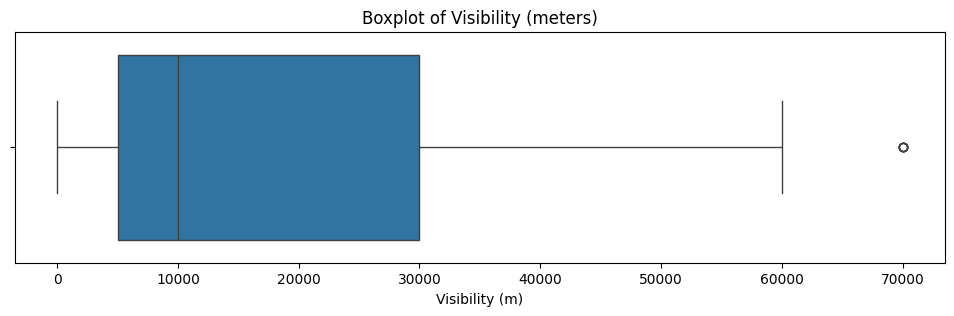

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove NaN values for plotting
vis_data = df["visibility_m"].dropna()

# Histogram
plt.figure(figsize=(12,5))
sns.histplot(vis_data, bins=100, kde=False)
plt.title("Histogram of Visibility (meters)")
plt.xlabel("Visibility (m)")
plt.ylabel("Count")
plt.show()

# Boxplot (good for spotting outliers)
plt.figure(figsize=(12,3))
sns.boxplot(x=vis_data)
plt.title("Boxplot of Visibility (meters)")
plt.xlabel("Visibility (m)")
plt.show()

### Temperature, DEW, SLP
1. Split the compound field
2. keep the measurement only if the quality is 1

In [178]:
# Split TMP into temperature and quality
tmp_parts = df["TMP"].fillna("").str.split(",", expand=True)

# Convert temperature to numeric (values are °C * 10)
df["temperature_C"] = pd.to_numeric(tmp_parts[0], errors="coerce") / 10.0
df["temperature_qlt"] = pd.to_numeric(tmp_parts[1], errors="coerce")

df.loc[df["temperature_qlt"] != 1, "temperature_C"] = np.nan

# Optional: drop the original TMP column
df.drop(columns=["TMP", "temperature_qlt"], inplace=True)

# Inspect
print(df["temperature_C"].describe())


count    130293.000000
mean          9.937908
std           8.582025
min         -14.000000
25%           3.000000
50%           9.400000
75%          16.700000
max          35.400000
Name: temperature_C, dtype: float64


In [179]:
# Split TMP into temperature and quality
slp_parts = df["SLP"].fillna("").str.split(",", expand=True)

# Convert temperature to numeric (values are °C * 10)
df["SLP_hpa"] = pd.to_numeric(slp_parts[0], errors="coerce") / 10.0
df["SLP_qlt"] = pd.to_numeric(slp_parts[1], errors="coerce")

df.loc[df["SLP_qlt"] != 1, "SLP_hpa"] = np.nan

# Optional: drop the original TMP column
df.drop(columns=["SLP", "SLP_qlt"], inplace=True)

# Inspect
print(df["SLP_hpa"].describe())


count    43396.000000
mean      1017.115112
std          8.686429
min        985.400000
25%       1011.800000
50%       1017.200000
75%       1022.600000
max       1047.100000
Name: SLP_hpa, dtype: float64


In [180]:
# Split TMP into temperature and quality
dew_parts = df["DEW"].fillna("").str.split(",", expand=True)

# Convert temperature to numeric (values are °C * 10)
df["DEW_C"] = pd.to_numeric(dew_parts[0], errors="coerce") / 10.0
df["DEW_qlt"] = pd.to_numeric(dew_parts[1], errors="coerce")

df.loc[df["DEW_qlt"] != 1, "DEW_C"] = np.nan

# Optional: drop the original TMP column
df.drop(columns=["DEW", "DEW_qlt"], inplace=True)

# Inspect
print(df["DEW_C"].describe())


count    130309.000000
mean          5.442331
std           7.307677
min         -18.000000
25%           0.000000
50%           5.000000
75%          11.400000
max          23.000000
Name: DEW_C, dtype: float64


## Save to csv after basic preprocessing

In [181]:
df.to_csv("../data/processed/weather_basic_preprocessing.csv", index=False)

In [182]:
# % of missing values per column
missing_percent = df.isna().mean() * 100
print(missing_percent.sort_values(ascending=False))

ceiling_height_ft    78.013934
GA2                  74.032441
MW1                  72.427260
SLP_hpa              66.702474
MD1                  66.660273
visibility_m         49.779786
GA1                  30.107882
GE1                  30.107882
wind_dir_sin         29.543920
wind_dir_cos         29.543920
GF1                  24.924805
wind_speed_raw        3.614726
ceiling_coverage      0.775735
temperature_C         0.026855
DEW_C                 0.014579
MA1                   0.000767
DATE                  0.000000
REPORT_TYPE           0.000000
year_file             0.000000
dtype: float64


# Example hour that has two reports

In [183]:
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

report_counts = df.groupby("DATE")["REPORT_TYPE"].nunique().reset_index(name="num_report_types")

# Group by timestamp and keep only those with multiple reports
dupes = df.groupby("DATE").filter(lambda g: g["REPORT_TYPE"].nunique() > 1)

# Pick one example timestamp
example_time = dupes["DATE"].iloc[0]
subset = df[df["DATE"] == example_time]

# Compare reports row by row: keep only differing columns
diff_cols = subset.loc[:, (subset.nunique(dropna=False) > 1)]
print(f"🔎 Example time: {example_time}")
print(diff_cols)

🔎 Example time: 2019-01-01 00:00:00
  REPORT_TYPE                 GA1                 GA2  \
0       FM-12  07,1,+00800,1,06,1                 NaN   
1       FM-15  02,1,+00640,1,99,9  07,1,+00884,1,99,9   

                                   GF1              MA1               MD1  \
0  08,99,1,07,1,99,9,00800,1,99,9,99,9  99999,9,09996,1  8,1,011,1,+999,9   
1  99,99,9,02,1,99,9,00640,1,99,9,99,9  10280,1,99999,9               NaN   

    MW1  wind_speed_raw  temperature_C  SLP_hpa  DEW_C  
0  10,1            30.0            0.1   1030.2   -0.9  
1   NaN            26.0            0.0      NaN   -1.0  


### We will keep FM-15 as the base report due to bigger coverage

In [184]:
report_counts = df["REPORT_TYPE"].value_counts()
print(report_counts)

REPORT_TYPE
FM-15    86875
FM-12    43452
FM-16        1
Name: count, dtype: int64
